In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import FunctionLib
import math
#%matplotlib widget
basePath ='./sims.TNG/TNG50-1/output'
from tqdm import tqdm
import gc
import os

In [2]:
basePath = './sims.TNG/TNG50-1/output'
initial_snapshot = 84
end_snapshot = 99

halos_fields = ['GroupFirstSub', 'GroupNsubs', 'GroupMass', 'GroupPos']
subhalos_fields = ['SubhaloGrNr', 'SubhaloMass', 'SubhaloPos']
tree_fields = ['SubfindID', 'SnapNum']

In [42]:
halos_data = il.groupcat.loadHalos(basePath, end_snapshot, fields=halos_fields)
subhalos_data = il.groupcat.loadSubhalos(basePath, end_snapshot, fields=subhalos_fields)

In [41]:
subhalos_data['SubhaloPos'][0]

array([  7311.77001953,  24565.50390625,  21472.859375  ], dtype=float32)

In [4]:
first_subhalo_id = halos_data['GroupFirstSub']
n_subhalos = halos_data['GroupNsubs']
group_mass = halos_data['GroupMass']
subhalos_grnr = subhalos_data['SubhaloGrNr']
subhalos_mass = subhalos_data['SubhaloMass']

In [5]:
galaxy_mass_inf = 30
galaxy_mass_sup = 500
condition = (group_mass >= galaxy_mass_inf) & (group_mass <= galaxy_mass_sup)
mw_like_index = np.where(condition)[0]

In [6]:
def Binary_DataIter(Data_Set1,Data_Set2):
    for i in range(0,min(len(Data_Set1),len(Data_Set2))):
        yield Data_Set1[i],Data_Set2[i]

In [8]:
pos_array_list = []

fields = ['SubhaloPos']
for current_snapshot in tqdm(range(initial_snapshot, end_snapshot + 1)):
    pos_array_list.append(il.groupcat.loadSubhalos(basePath, current_snapshot, fields))


100%|██████████| 16/16 [05:45<00:00, 21.59s/it]


In [9]:
distances = []
is_first_approach_indices=[]
is_4mass=[]
for i in tqdm(mw_like_index):
    first_subhalo_index = first_subhalo_id[i]
    if first_subhalo_index == -1:
        continue
    if n_subhalos[i] == 1:
        continue

    mass_array = np.array([])
    for j in range(n_subhalos[i]):
        subhalo_id = first_subhalo_index + j
        mass_array = np.append(mass_array, subhalos_mass[subhalo_id])

    host_id = first_subhalo_index + np.argsort(mass_array)[-1]
    mms_id = first_subhalo_index + np.argsort(mass_array)[-2]

    mass_host = mass_array[np.argsort(mass_array)[-1]]
    mass_mms = mass_array[np.argsort(mass_array)[-2]]
    
    if (mass_host/mass_mms<4): continue
        
    is_4mass.append(i)
    
    host_tree = il.sublink.loadTree(basePath, initial_snapshot, host_id, fields=tree_fields)
    mms_tree = il.sublink.loadTree(basePath, initial_snapshot, mms_id, fields=tree_fields)

    host_subfind_id = host_tree['SubfindID']
    mms_subfind_id = mms_tree['SubfindID']
    
    distances = []
    for current_snapshot in range(initial_snapshot, end_snapshot + 1):
        
        current_host_id = host_subfind_id[current_snapshot - initial_snapshot]
        current_mms_id = mms_subfind_id[current_snapshot - initial_snapshot]

        position_data = pos_array_list[end_snapshot - current_snapshot]

        current_host_position = position_data[current_host_id]
        current_mms_position = position_data[current_mms_id]

        distance = np.linalg.norm(current_host_position - current_mms_position)
        distances.append(distance)
    
    if distances and distances[-1] == min(distances):is_first_approach_indices.append(i)
    
    snapshots = np.arange(initial_snapshot, end_snapshot + 1)
    plt.plot(snapshots, np.array(distances))
    plt.xlabel('Snapshot')
    plt.ylabel('Distance between Host and MMS')
    plt.title('Distance between Host and MMS over Time')
    plt.grid()
    fig_name = f"{i}_first_approach.png"
    save_path = './FirstApp/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, fig_name))
    plt.close("all")

100%|██████████| 482/482 [01:22<00:00,  5.81it/s]


In [22]:
len(is_first_approach_indices)

12

In [17]:
is_first_approach_indices

[48, 82, 96, 150, 166, 177, 233, 255, 273, 275, 282, 423, 446]

In [23]:
len(is_4mass)

419

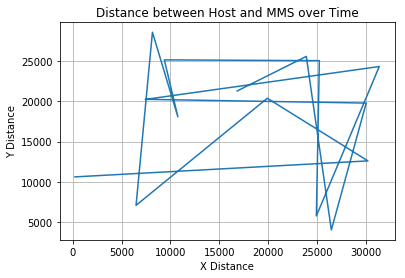

In [19]:
if(1):
    i=55
    first_subhalo_index = first_subhalo_id[i]

    mass_array = np.array([])
    for j in range(n_subhalos[i]):
        subhalo_id = first_subhalo_index + j
        mass_array = np.append(mass_array, subhalos_mass[subhalo_id])

    host_id = first_subhalo_index + np.argsort(mass_array)[-1]
    mms_id = first_subhalo_index + np.argsort(mass_array)[-2]

    mass_host = mass_array[np.argsort(mass_array)[-1]]
    mass_mms = mass_array[np.argsort(mass_array)[-2]]
    

    
    host_tree = il.sublink.loadTree(basePath, end_snapshot, host_id, fields=tree_fields)
    mms_tree = il.sublink.loadTree(basePath, end_snapshot, mms_id, fields=tree_fields)

    host_subfind_id = host_tree['SubfindID']
    mms_subfind_id = mms_tree['SubfindID']
    
    xs = []
    ys=[]
    for current_snapshot in range(initial_snapshot, end_snapshot + 1):
        current_tree_index=end_snapshot-current_snapshot
        
        current_host_id = host_subfind_id[current_tree_index]
        current_mms_id = mms_subfind_id[current_tree_index]

        position_data = pos_array_list[current_tree_index]

        current_host_position = position_data[current_host_id]
        current_mms_position = position_data[current_mms_id]

        current_host_position=np.mod(current_host_position,35000)

        
        distance = (current_host_position)
        
        xs.append(distance[0])
        ys.append(distance[1])
        
    snapshots = np.arange(initial_snapshot, end_snapshot + 1)
    plt.plot(xs, ys)
    plt.xlabel('X Distance')
    plt.ylabel('Y Distance')
    plt.title('Distance between Host and MMS over Time')
    plt.grid()
    fig_name = f"{i}.png"
    save_path = './'
    #os.makedirs(save_path, exist_ok=True)
    #plt.savefig(os.path.join(save_path, fig_name))
    plt.show()
    plt.close("all")

In [20]:
host_tree

{'count': 112,
 'SubfindID': array([ 351320,  350993,  347569,  345005,  343229,  339773,  338813,
         334767,  329770,  326908,  319156,  324252,  321990,  317747,
         315342,  309268,  302932,  297952,  296354,  292619,  290327,
         286549,  285109,  277520,  274140,  267140,  271847,  265247,
         268726,  265244,  261489,  249579,  247386,  245497,  240451,
         236073,  229995,  228634,  227159,  218102,  212727,  215002,
        1020343,  205743,  203420,  199844,  193713,  211734,  206703,
         203847,  209877,  200930, 2140269, 2271306, 2312927, 2320062,
        2294357, 2375829, 2193409, 2162973, 2508543, 2433483, 2394635,
        2384091, 2416393, 1738736, 2487734, 2538088, 2636488, 2698991,
        2575696, 2507522, 2606523, 2930972, 2836033, 2688178, 3305695,
        3656808, 5132746, 5234349, 4022624, 3195548, 4544040, 5912394,
        4714446, 7624140, 5739613, 6161651, 4542937, 4796059, 5242577,
        5387596, 3656809, 5931315, 5553117, 59296

In [ ]:
        current_host_id = host_subfind_id[current_snapshot - initial_snapshot]
        current_mms_id = mms_subfind_id[current_snapshot - initial_snapshot]

        position_data = pos_array_list[end_snapshot - current_snapshot]

        current_host_position = position_data[current_host_id]
        current_mms_position = position_data[current_mms_id]

        distance = (current_host_position - current_mms_position)
        xs.append(distance[0])
        ys.append(distance[1])
    
    snapshots = np.arange(initial_snapshot, end_snapshot + 1)
    plt.plot(xs, ys)
    plt.xlabel('X Distance')
    plt.ylabel('Y Distance')
    plt.title('Distance between Host and MMS over Time')
    plt.grid()
    fig_name = f"{i}.png"
    save_path = './'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, fig_name))
    plt.close("all")